# 1. Setup

In [1]:
from urllib.request import urlretrieve

import plotly.express as px
from sklearn.linear_model import LinearRegression

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
def download_nhts():
    url = 'https://nhts.ornl.gov/assets/2016/download/csv.zip'
    outpath = '../data/nhts/2017/data.zip'
    urlretrieve(url, mkfile(outpath))
    
# download_nhts()

In [3]:
pd.read_csv('../data/nhts/2017/trippub.csv', nrows=2)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300


## 2.2. Trips table

In [4]:
def get_trip_data(overwrite=False, seed=1234):
    outpath = Path('../data/nhts/trips.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    trip = pd.read_csv('../data/nhts/2017/trippub.csv').rename(columns=str.lower)
    df = Pdf()
    def cut(col: str, bins: list[float], labels: list[str]) -> pd.Categorical:
        return pd.cut(trip[col], [-INF] + bins + [INF], True, labels)
    def classify(col: str, mapping: dict) -> pd.Categorical:
        cats = Series(list(mapping.values())).drop_duplicates().to_list()
        return pd.Categorical(trip[col].map(mapping), categories=cats)
    ## Add Gaussian noise to the duration values
    df['RawDuration'], df['Duration'] = [trip['trvlcmin']] * 2 # in minutes
    np.random.seed(seed)
    for mu in np.arange(5, 91, 5): # noisify every 5 minutes
        idx = df[df.Duration == mu].index
        sample = np.random.normal(mu, 5 / 2, size=len(idx))
        df.loc[idx, 'Duration'] = sample
    ## Other deterrence measures
    df['Distance'] = trip['trpmiles'] * MI2M / 1000 # in km
    df['Speed'] = (df.Distance / (df.Duration / 60)) # in km/h
    for col, vmax in D(Distance=200, Duration=120, Speed=100).items():
        df.loc[(df[col] <= 0) | (df[col] > vmax), col] = np.nan
    df['LogDistance'] = np.log10(1 + df.Distance * 1000) # distance in meters
    # estimated gas price in $ assuming a constant mileage of 20 mi/ga
    # df['Cost'] = (trip['gasprice'] / 100) * (df.Distance * 1000 / MI2M) / 20
    df['TripWeight'] = normalize(trip['wttrdfin'])
    # ## Assign a flag to the rows about whether their peak duration values are sampled
    ## Trip attributes
    df['Mode'] = classify('trptrans', {x: 'Drive' for x in [3, 4, 5, 6, 17, 18]} | 
                                      {x: 'Transit' for x in [10, 11, 12, 13, 14, 15, 16]} |
                                      {1: 'Walk', 2: 'Bike'})
    df['HomeBased'] = (trip['trippurp'] == 'NHB').map({False: 'Yes', True: 'No'})
    df['Purpose'] = classify('whytrp90', {1: 'Work', 2: 'Work', 3: 'Shopping',
                                          4: 'Social', 5: 'Social', 6: 'Medical',
                                          8: 'Social', 10: 'Recreation'})
    df['VehType'] = classify('vehtype', {1: 'Car', 2: 'Van', 3: 'SUV', 4: 'Pickup'} | 
                             {x: 'Other' for x in [-1, 5, 6, 7]})
    df['Weekend'] = classify('tdwknd', {1: 'Yes', 2: 'No'})
    # df['Occupancy'] = cut('numontrp', [1, 2], ['Single', 'Pair', 'Multiple'])
    df['GasPrice'] = cut('gasprice', [233, 267], ['Low', 'Mid', 'High'])
    df['StayTime'] = cut('dweltime', [15, 60, 480], ['Short', 'Mid', 'Long', 'Very_Long'])
    df['StartTime'] = (pd.cut(trip['strttime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'Off-peak', 'Morning Peak', 'Off-peak', 'Evening Peak', 'Off-peak'], ordered=False)
                       .cat.reorder_categories(['Morning Peak', 'Evening Peak', 'Off-peak']))
    ## SES of respondent/household
    # df['Age'] = normalize(trip['r_age'].clip(0, 80))
    df['Age'] = cut('r_age', [0, 30, 64], ['n/a', 'Young', 'Mid', 'Senior'])
    df['Sex'] = classify('r_sex', {1: 'Male', 2: 'Female'})
    df['Race'] = classify('hh_race', {1: 'White'} | {x: 'Non-White' for x in [2, 3, 4, 5, 6]})
    df['Hispanic'] = classify('hh_hisp', {1: 'Yes', 2: 'No'})
    df['Education'] = cut('educ', [0, 2], ['n/a', 'School', 'College'])
    df['Worker'] = classify('worker', {1: 'Yes', 2: 'No'})
    df['Income'] = cut('hhfaminc', [0, 5, 7], ['n/a', 'Low', 'Mid', 'High'])
    df['HomeOwn'] = classify('homeown', {1: 'Own', 2: 'Rent'})
    ## Origin/destination attributes
    # df['Region'] = cut('census_r', [1, 2, 3], ['Northeast', 'Midwest', 'South', 'West'])
    df['Subway'] = classify('msacat', {1: 'Yes', 2: 'No', 3: 'N/A', 4: 'N/A'})
    df['UrbanO'] = classify('obhur', D(R='Rural', S='Suburban', T='Suburban', C='Urban', U='Urban'))
    df['UrbanD'] = classify('dbhur', D(R='Rural', S='Suburban', T='Suburban', C='Urban', U='Urban'))
    df['PopDensityO'] = cut('otppopdn', [0, 1000, 4000], ['n/a', 'Low', 'Mid', 'High'])
    df['PopDensityD'] = cut('dtppopdn', [0, 1000, 4000], ['n/a', 'Low', 'Mid', 'High'])
    df['HouseDensityO'] = cut('otresdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['HouseDensityD'] = cut('dtresdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['EmpDensityO'] = cut('oteempdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['EmpDensityD'] = cut('dteempdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    ## Remove bad dataa
    df = df.replace('n/a', None)
    print('NaNs: ' + ' '.join([f'{k}={v:,}' for k, v in df.isna().sum().items() if v > 0]))
    df = df.dropna().reset_index(drop=1)
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype(CAT)
    df.to_parquet(mkfile(outpath))
    return df

trips = get_trip_data(overwrite=1).disp() # t=0:08

NaNs: Duration=15,995 Distance=9,530 Speed=30,852 LogDistance=9,530 Mode=9,540 Purpose=35,779 VehType=458 StartTime=544 Age=1,216 Sex=711 Race=19,553 Hispanic=1,002 Education=65,579 Worker=79,323 Income=24,340 HomeOwn=6,308 UrbanO=980 UrbanD=962 PopDensityO=973 PopDensityD=955 HouseDensityO=973 HouseDensityD=955 EmpDensityO=973 EmpDensityD=955
729,739 rows x 31 cols; Memory: 50.8 MiB


,RawDuration,Duration,Distance,Speed,LogDistance,TripWeight,Mode,HomeBased,Purpose,VehType,...,HomeOwn,Subway,UrbanO,UrbanD,PopDensityO,PopDensityD,HouseDensityO,HouseDensityD,EmpDensityO,EmpDensityD
,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,15,16.182075,8.439379,31.291583,3.926362,0.006319,Drive,Yes,Social,Car,...,Own,N/A,Suburban,Suburban,Mid,Low,Mid,Low,Mid,Low


# 3. Analyze

## 3.1. Sample sizes

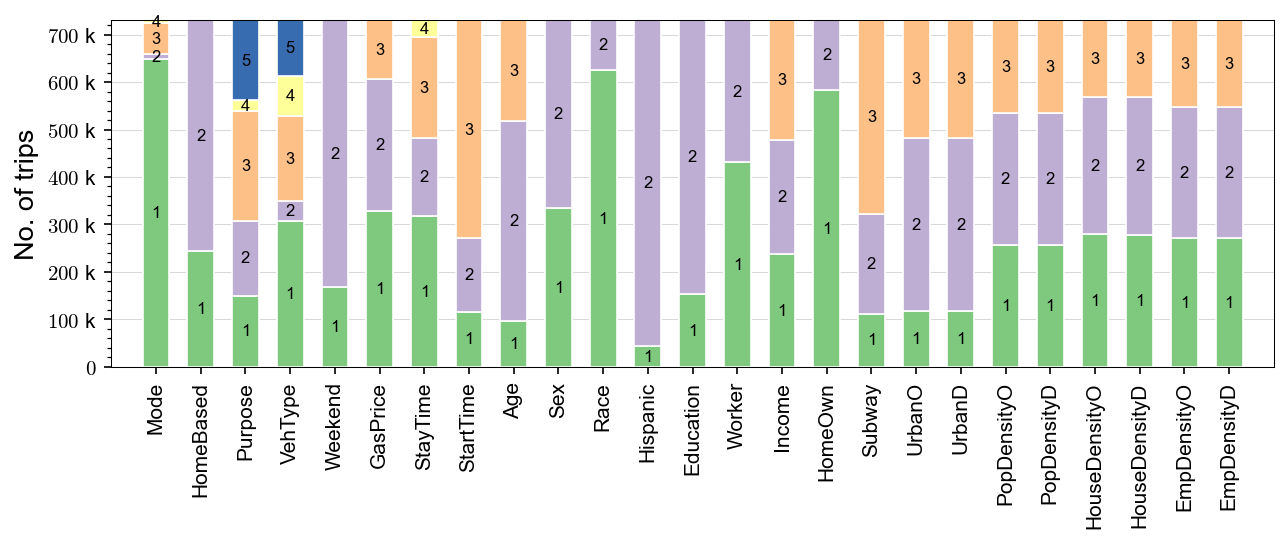

In [7]:
def plot_sample_sizes(trips, size=(10, 3), dpi=150, width=0.6, cmap='Accent'):
    cols = trips.select_dtypes(CAT).columns
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', yeng=1, xminor=0,
               xlim=(-1, len(cols)), ylim=(0, len(trips)))
    for i, col in enumerate(cols):
        df = trips[col].value_counts().rename('n').sort_index().reset_index()
        df['bottom'] = df.n.cumsum().shift().fillna(0)
        df['color'] = [mpl.colors.to_hex(x) for x in sns.color_palette(cmap, len(df))]
        for j, r in df.iterrows():
            ax.add_artist(mpl.patches.Rectangle(
                (i - width / 2, r.bottom), width, r.n, color=r.color, ec='w', lw=0.8))
            ax.text(i, r.bottom + r.n / 2, str(j + 1), fontsize=8, ha='center', va='center')
    plt.xticks(range(len(cols)), cols, rotation=90)

plot_sample_sizes(trips, dpi=150)

In [8]:
def plot_sample_sizes(data, size=(14, 4), dpi=150):
    df = pd.concat([data[col].value_counts().rename_axis('subcat')
                    .reset_index().assign(cat=col) 
                    for col in data.select_dtypes(CAT)])
    df = df.sort_values('cat')
    df['label'] = df.cat + '__' + df.subcat
    df['color'] = df.cat.map(dict(zip(df.cat.unique(), sns.color_palette(
        'Set1', df.cat.nunique()))))
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', xlim=(-1, len(df)), 
               title='Sample size for classifications of measures', yeng=1)
    ax.bar(df.label, df['count'], color=df.color)
    ax.tick_params(which='minor', bottom=False)
    plt.xticks(rotation=90)

# plot_sample_sizes(trips, dpi=150)

## 3.2. Target vars (deterrence)

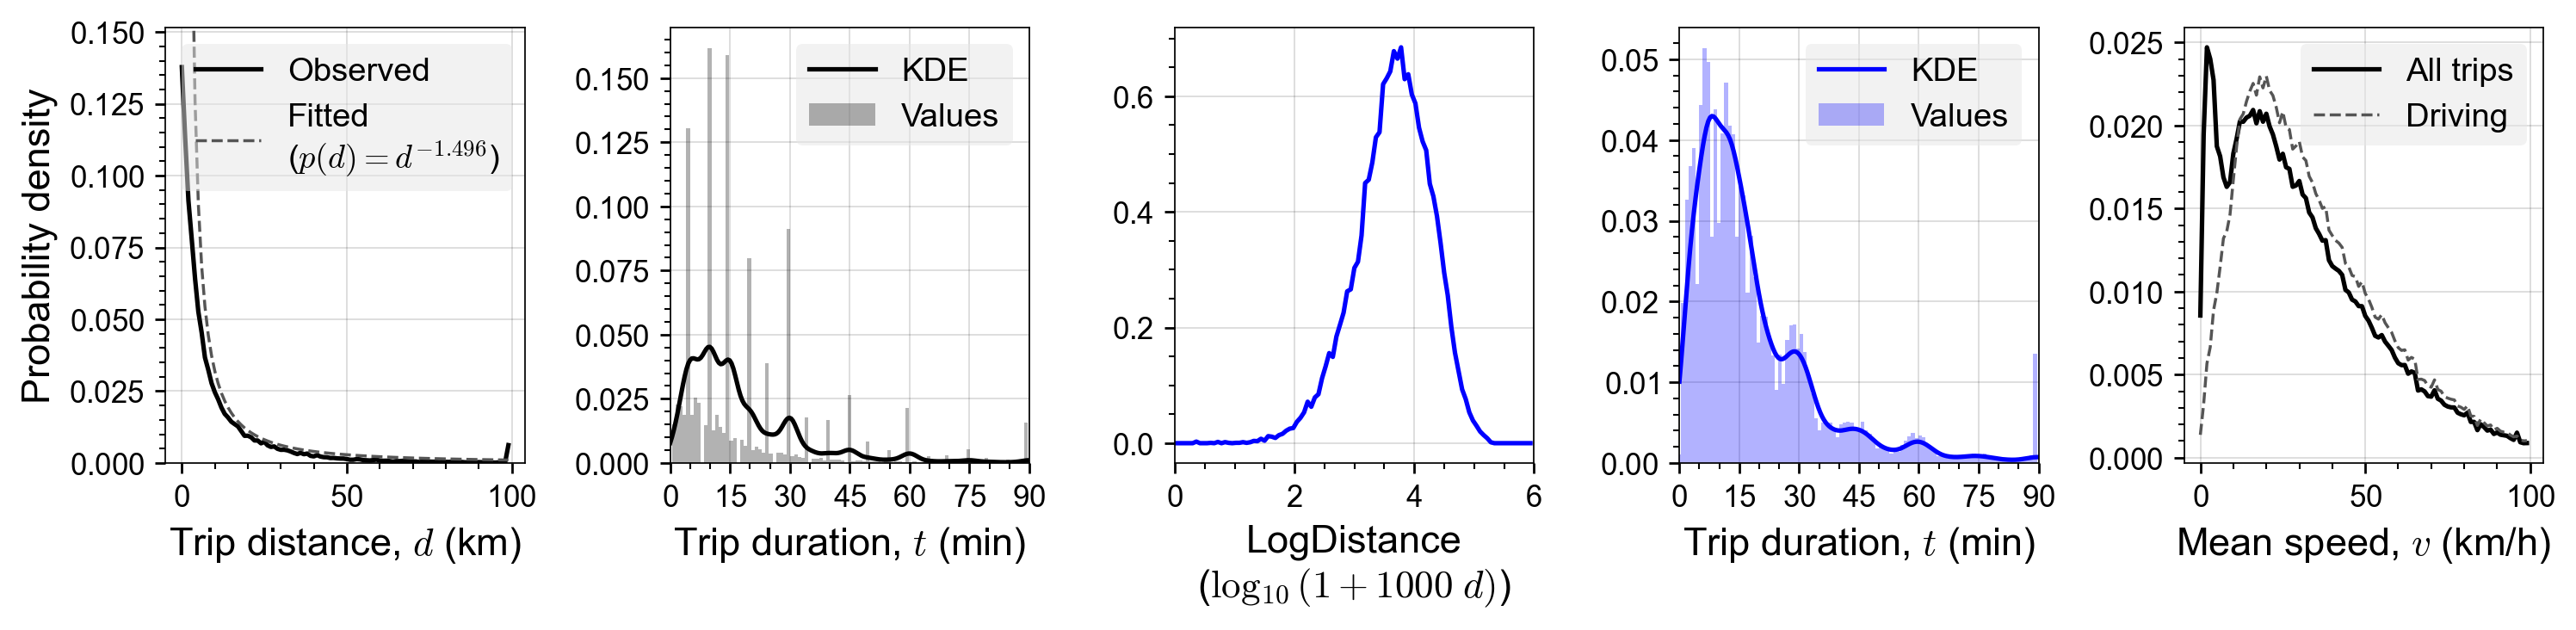

In [9]:
def fig_deterrence_distr(data=trips, size=(12, 3), dpi=150):
    def hist(target, vmax=None, bins=100, query=None):
        df = data.query(query) if query else data
        y, x = np.histogram(df[target].clip(0, vmax), density=True,
                            bins=np.linspace(0, vmax, bins + 1), weights=df.TripWeight)
        return x[:-1], y
    _, axes = plt.subplots(1, 5, figsize=size, dpi=dpi)
    ## Distance
    ax = pplot(axes[0], xlab='Trip distance, $d$ (km)', ylab='Probability density')
    x, y = hist('Distance', 100)
    ax.set_ylim(ymax=y.max() * 1.1)
    ax.plot(x, y, color='k', label='Observed')
    reg = LinearRegression(fit_intercept=False)
    lnx, lny = np.log(1e-6 + x).reshape((-1, 1)), np.log(y)
    a = reg.fit(lnx, lny).coef_[0]
    label = 'Fitted\n($p(d)=d^{%.3f}$)' % a
    ax.plot(x, (1e-6 + x) ** a, ls='--', lw=1, color='#555', label=label)
    ax.legend()
    ## Original and modified trip durations
    for i, var, color in [(1, 'RawDuration', 'k'), (3, 'Duration', 'b')]:
        ax = pplot(axes[i], xlab='Trip duration, $t$ (min)', xlim=(0, 90))
        ax.bar(*hist(var, 90), color=color, width=0.9, alpha=0.3, label='Values')
        sns.kdeplot(data[var], ax=ax, bw_adjust=1.75, clip=(0, 90), 
                    color=color, label='KDE')
        ax.set_ylabel('')
        ax.legend()
        ax.set_xticks(np.arange(0, 91, 15))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## LogDistance
    ax = pplot(axes[2], xlim=(0, 6), xlab='LogDistance\n($\log_{10}(1 + 1000\;d)$)')
    ax.plot(*hist('LogDistance', 6), color='b')
    ## Speed
    ax = pplot(axes[4], xlab='Mean speed, $v$ (km/h)')
    ax.plot(*hist('Speed', 100), color='k', label='All trips')
    ax.plot(*hist('Speed', 100, query='Mode=="Drive"'), 
            color='#555', ls='--', lw=1, label='Driving')
    ax.legend()
    plt.tight_layout()
    imsave('NHTS deterrence distributions', root='../fig/nhts')

x = fig_deterrence_distr(dpi=250); x # t=0:10